In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import pymadx
from xcoll_plotting import plot_functions as xcp
import scipy
import io



# insert twocryst setup
TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'

No pytransport functionality
No pytransport functionality


In [2]:
# FUNCTION TO FIND BAD APERTURES IN LINE THAT PREVENT CLOSED ORBIT SEARCH

def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers


In [3]:
# SPECIFIC CONVERSION FUNCTIONS home

def change_coordinates_to_b1(df, end_s):
    
    if 's' in df.columns:
        new_s = end_s - df['s']
        df['s'] = new_s
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df


def reset_coord_cry_tracking(df, twiss, end_s, TCCS_loc, TCCS_name):
    df['s'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'], 2*end_s-TCCS_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCS_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def extract_channelled(df, end_s, TCCS_loc, TCLA_loc):
    df = df.loc[(df['s']<end_s-TCCS_loc) & (df['s']>end_s-TCLA_loc)]
    return df


def filter_aperture_rotations(df, line):    
    aperture_offsets = []
    for name, element in line.element_dict.items():
        if '_tilt_entry' in name and element.__class__.__name__.startswith('SRotation'):
            aper_name = name.split('_tilt')[0]
            aperture_offsets.append(aper_name)#[aper_name] = (element.s)

    return df[~df['name'].str.contains('|'.join(aperture_offsets), case=False)]

In [4]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3



In [5]:
def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}
        bend = {}
        xdim = {}
        ydim = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6 or sline[0].lower() == "crystal" or sline[0].lower() == "target":
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "crystal":
                    bend[sline[1]] = float(sline[2])
                    xdim[sline[1]] = float(sline[3])
                    ydim[sline[1]] = float(sline[4])
                elif sline[0].lower() == "target":
                    xdim[sline[1]] = float(sline[2])
                    ydim[sline[1]] = float(sline[3])
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["angle"] = df["angle"] 
    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["gap"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    df["bend"] = df["name"].apply(lambda s: bend.get(s, 0))
    df["xdim"] = df["name"].apply(lambda s: xdim.get(s, 0))
    df["ydim"] = df["name"].apply(lambda s: ydim.get(s, 0))
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name").T

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.columns) # The data fram was transposed so columns are names
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    return df.T



In [6]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]
        if 'gap' in parameters.index:
            nsigma = parameters["gap"]
        elif 'nsigma' in parameters.index:
            nsigma = parameters["nsigma"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam = 2):
    
    if filename.endswith('.yaml'):
        # load collimators form yaml file as pandas
        with open(filename, 'r') as file:
            collimators = yaml.safe_load(file)   
        coll_dict  = collimators['collimators'][f'b{beam}']
        df = pd.DataFrame.from_dict(coll_dict, orient="index")
    else:
        df  = load_colldb_new(filename)
    df = df.rename_axis('name').reset_index()
    coll_list = df['name'].to_list()
    
    # merge it with dataframe from twiss
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot


In [7]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane, df_twiss, end_s, df_chann, plot_offplane_coll = True):


    #coll_data = change_coordinates_to_b1(coll_data, end_s)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s"]
        hgap    = coll["opening"]

        if(coll['name'] == TCCS_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCS_name]['s'])
            hgap = df_twiss[df_twiss['s'] == s_centre]['n_sigma_y'].iloc[0]
        elif(coll['name'] == TCCP_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0]
        
        elif(coll['name'] == TARGET_name):
            continue


        orbit = coll['x'] if plane=='h' else coll['y']
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        
        if coll['side'] == 'left':
            color = 'r' if not pd.isna(coll['crystal']) else 'k'
            jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw, zorder=10)
            ax.add_patch(jaw)

        elif coll['side'] == 'right': 
            color = 'r' if not pd.isna(coll['crystal']) else 'k'      
            jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw,  zorder=10)
            ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)


    if plot_offplane_coll:
        for index, coll in off_plane_collimators.iterrows():
            s_centre = coll["s"]
            sstart  = s_centre - coll["length"]/2
            send    = s_centre + coll["length"]/2
            orbit = coll['x'] if plane=='h' else coll['y']

            alpha = 1
            color = 'slategray'
            edcgecolor = 'slategray'

            coll_angle = coll['angle']
            coll_opening = coll['opening']
            if plane == 'h':
                hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                        if not np.isclose(np.cos(coll_angle), 0) else np.inf)
            elif plane == 'v':
                hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                        if not np.isclose(np.sin(coll_angle), 0) else np.inf)

            if np.isnan(hgap) or hgap > 0.900:
                hgap = 0 # Closed bars for non-cut collimators
                alpha = 1
                color = 'lightgray'
                edcgecolor = 'lightgray'

            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2
            h       = top_lim - hgap
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)
            
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)

            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)

In [8]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, end_s, df_coll=None, s_start=6300, s_stop=7100):
    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)
    TCLA_loc  = 20084.662375965734
    
    plot_axis.plot(df_ref["s"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s"],df_ref["n_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s"],-df_ref["n_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s"], df_ref["n_sigma_y"], -df_ref["n_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=17)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=17)
    plot_axis.grid(linestyle=':')
    #plot_axis.set_yticks(ticks=plt.yticks()[0], labels=[f"{x*1e3:.{0}f}" for x in plt.yticks()[0]])
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    # convert, xcp function handles dataframe in m
    xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), plot_axis, "v")
    
    if df_coll is not None:
        df_coll = change_coordinates_to_b1(df_coll, end_s)
        plot_collimators(df_coll, plot_axis, "v", df_twiss = df_ref, df_chann = df_chann, end_s = end_s, plot_offplane_coll = False)

# Load and Set-up

In [9]:
## Choose a context
context = xo.ContextCpu()         # For CPU

In [10]:
def calc_nsigma(df_twiss, df_chann, emittance_phy, obj_name, add_offset = 0):

    s_centre = float(df_twiss[df_twiss["name"] == obj_name]['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0] - add_offset
    beta_y = float(df_twiss[df_twiss["name"] == obj_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['n_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma, hgap 


def run_cry_tracking(line_name, normalized_emittance, part_energy, n_sigma, TCLA_gap = 9.0, **kwargs):    

# Load from json
    line = xt.Line.from_json(line_name)
    if part_energy is not None:
        line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
    print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')

    end_s = line.get_length()

    TCCS_name = 'tccs.5r3.b2'
    TCCP_name = 'tccp.4l3.b2'
    TARGET_name = 'target.4l3.b2'
    PIXEL_name = 'pixel.detector_1'
    TFT_name = 'tft.detector'
    TCP_name = 'tcp.d6r7.b2'
    TCLA_name = 'tcla.a5l3.b2'


    RPX_bottom_wall_thickess = 2.14e-3
    PIX_y_distance_to_RPX = 4.26e-3

    TCCS_loc_abs  = 6773.9428  #6773.7 #6775
    TCCP_loc_abs  = 6653.2543  #6653.3 #6655
    PIX1_loc_abs = 6652.7039
    PIX2_loc_abs = 6652.6929
    PIX3_loc_abs = 6652.6819
    TFT_loc_abs = 6652.114

    TCCS_loc = end_s - TCCS_loc_abs
    TCCP_loc = end_s - TCCP_loc_abs
    TARGET_loc = end_s - (TCCP_loc_abs + 0.070/2 +  0.005/2)
    PIX1_loc = end_s - PIX1_loc_abs
    PIX2_loc = end_s - PIX2_loc_abs
    PIX3_loc = end_s - PIX3_loc_abs
    TFT_loc = end_s - TFT_loc_abs
    TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
    TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
    line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name)
    line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+ '_aper')
    line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)

    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])

    line.build_tracker(_context=context)

    # compute critical angle
    beta_rel = line.particle_ref._xobject.beta0[0]
    gamma = line.particle_ref._xobject.gamma0[0]
    energy = line.particle_ref._xobject.p0c[0]

    bend = 80.00

    emittance_phy = normalized_emittance/(beta_rel*gamma)

    dp = 1.92e-10 
    pot_crit = 21.34 #16 #eV Silicon
    eta = 0.9
    Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
    critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/bend)

    '''pot_well_Si = 21
    energy_well_Si = 5.7e9 / 1e-2 #eV/m
    Rcrit = energy/energy_well_Si
    xp_crit0 = np.sqrt(2*pot_well_Si/(energy*beta_rel))
    critical_angle = xp_crit0*(1-Rcrit/bend)'''

    # set up particles
    twiss = line.twiss()
    beta_y_cry1  = twiss['bety', TCCS_name]
    alpha_y_cry1 = twiss['alfy', TCCS_name]

    cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            x=0,
                            px=0,
                            y=n_sigma*np.sqrt(emittance_phy*beta_y_cry1),
                            py=-n_sigma*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                            _context=context)


    cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            x=0,
                            px=0,
                            y=n_sigma*np.sqrt(emittance_phy*beta_y_cry1),
                            py=-n_sigma*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                            _context=context)


    cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            x=0,
                            px=0,
                            y=n_sigma*np.sqrt(emittance_phy*beta_y_cry1),
                            py=-n_sigma*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                            _context=context)

    # track particles
    df_ref = change_coordinates_to_b1(twiss.to_pandas(), end_s)
    #df_ref = filter_aperture_rotations(df_ref, line)
    df_ref['n_sigma_y'] = n_sigma*np.sqrt(emittance_phy*df_ref['bety'])

    line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
    df_chann_part = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, end_s, TCCS_loc, TCCS_name)
    #df_chann_part = filter_aperture_rotations(df_chann_part, line)
    df_chann_part = extract_channelled(df_chann_part,end_s, TCCS_loc, TCLA_loc)

    line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
    df_chann_part_upper = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, end_s, TCCS_loc, TCCS_name)
    #df_chann_part_upper = filter_aperture_rotations(df_chann_part_upper, line)
    df_chann_part_upper = extract_channelled(df_chann_part_upper, end_s, TCCS_loc, TCLA_loc)

    line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
    df_chann_part_lower = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, end_s, TCCS_loc, TCCS_name)
    #df_chann_part_lower = filter_aperture_rotations(df_chann_part_lower, line)
    df_chann_part_lower = extract_channelled(df_chann_part_lower, end_s, TCCS_loc, TCLA_loc)

    upper_sig, upper_m = calc_nsigma(df_ref, df_chann_part_upper, emittance_phy, TCCP_name)
    central_sig, central_m =  calc_nsigma(df_ref, df_chann_part, emittance_phy, TCCP_name)
    lower_sig, lower_m =  calc_nsigma(df_ref, df_chann_part_lower, emittance_phy, TCCP_name)

    print(f'\nEnergy: {energy/1e9:.2f} GeV \t TCCS sigma setting: {n_sigma}' )
    print(f'\nUpper: {upper_sig:.2f} sigma, {upper_m*1e3:.2f} mm')
    print(f'Central: {central_sig:.2f} sigma, {central_m*1e3:.2f} mm')
    print(f'Lower: {lower_sig:.2f} sigma, {lower_m*1e3:.2f} mm')
    print(f'\nDimesion of the 5 sigma channelled spot (upper-lower): {(upper_m-lower_m)*1e3:.2f} mm   \tCrystal height: 2 mm')
    print(f'Center the spot in the crystal: [{central_m*1e3-1:.2f},{central_m*1e3+1:.2f}] mm')
    beta_y = float(df_ref[df_ref["name"] == TCCP_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)
    print(f'Jaw sigma in order to center: {(central_m-0.001)/sigma:.1f}')

    PIX_y_distance_to_RPX = 4.26e-3
    RPX_bottom_wall_thickess = 2.14e-3
   

    pix_lower_nsig, pix_lower_gap =  calc_nsigma(df_ref, df_chann_part_lower, emittance_phy, PIXEL_name, add_offset=PIX_y_distance_to_RPX + 1.5e-3)
    alfa_lower_nsig, alfa_lower_gap =  calc_nsigma(df_ref, df_chann_part_lower, emittance_phy, TFT_name, add_offset = RPX_bottom_wall_thickess+1.5e-3)

    print(f'\nPixel lower bound (+1.5mm margin): {pix_lower_nsig:.2f} sigma, {pix_lower_gap*1e3:.2f} mm')
    print(f'Alfa lower bound (+1.5mm margin): {alfa_lower_nsig:.2f} sigma, {alfa_lower_gap*1e3:.2f} mm')
     

    if 'ax_plot' in kwargs and kwargs['ax_plot']==True:
        df_apertures = xcp.load_apertures(line)
        df_apertures = change_coordinates_to_b1(df_apertures, end_s)
        if 'coll_name' in kwargs:
            df_coll = load_coll(kwargs['coll_name'], twiss.to_pandas(), xp.PROTON_MASS_EV, line.particle_ref.energy0)   
            df_coll = df_coll[df_coll['name']!='target.4l3.b2']
            if part_energy <500e9:                 
                y = TCLA_gap * df_coll[df_coll['name']=='tcla.a5l3.b2']["sigma_y"]
                df_coll.loc[df_coll['name']=='tcla.a5l3.b2', 'hgap'] = TCLA_gap
                df_coll.loc[df_coll['name']=='tcla.a5l3.b2', 'opening'] = y

        #start, stop = 6300 , 7100
        fig, ir3_plot = plt.subplots( figsize=(13,8))
        plot_IR3(ir3_plot, df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, end_s ,  df_coll = df_coll) #)

        if 'return_plot' in kwargs and kwargs['return_plot'] == True:
            return fig, ir3_plot

In [13]:
line_name_HL_IR7_ph = './input_files/HL_IR7_phase_advance/b4_sequence_patched_phadv.json'
normalized_emittance_HL = 2.5e-6
coll_name_HL = './input_files/colldbs/CollDB_HL_tight_b4.data'

In [12]:
run_cry_tracking(line_name = line_name_HL_IR7_ph, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 7.2)

Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.2

Upper: 38.32 sigma, 11.77 mm
Central: 36.98 sigma, 11.36 mm
Lower: 35.64 sigma, 10.95 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.36,12.36] mm
Jaw sigma in order to center: 33.7


In [11]:
line_name_HL_IR7 = './input_files/HL_IR7_rematched/b4_sequence_patched.json'
normalized_emittance_HL = 2.5e-6
coll_name_HL = './input_files/colldbs/CollDB_HL_tight_b4.data'

In [41]:
run_cry_tracking(line_name = line_name_HL_IR7, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 7.2)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.2

Upper: 38.21 sigma, 11.74 mm
Central: 36.87 sigma, 11.33 mm
Lower: 35.53 sigma, 10.92 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.33,12.33] mm
Jaw sigma in order to center: 33.6


In [48]:
run_cry_tracking(line_name = line_name_HL_IR7, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 7.7)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.7

Upper: 38.53 sigma, 11.84 mm
Central: 37.19 sigma, 11.43 mm
Lower: 35.85 sigma, 11.02 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.43,12.43] mm
Jaw sigma in order to center: 33.9


In [49]:
run_cry_tracking(line_name = line_name_HL_IR7, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 8.2)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 8.2

Upper: 38.85 sigma, 11.94 mm
Central: 37.51 sigma, 11.53 mm
Lower: 36.17 sigma, 11.12 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.53,12.53] mm
Jaw sigma in order to center: 34.3


In [50]:
run_cry_tracking(line_name = line_name_HL_IR7, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 8.7)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 8.7

Upper: 39.17 sigma, 12.04 mm
Central: 37.83 sigma, 11.63 mm
Lower: 36.49 sigma, 11.21 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.63,12.63] mm
Jaw sigma in order to center: 34.6


In [34]:
line_name_HL_IR7_IR3 = './input_files/HL_bkp/HL_IR7_IR3_rematched/b4_sequence_patched.json'
normalized_emittance_HL = 2.5e-6
coll_name_HL = './input_files/colldbs/CollDB_HL_tight_b4.data'

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_only_xtrack`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.2

Upper: 50.26 sigma, 11.34 mm
Central: 48.44 sigma, 10.93 mm
Lower: 46.62 sigma, 10.52 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [9.93,11.93] mm
Jaw sigma in order to center: 44.0


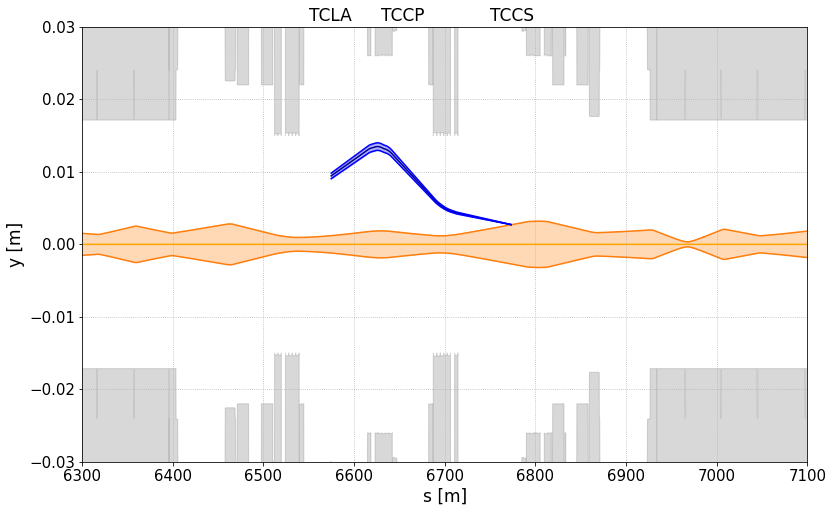

In [37]:
run_cry_tracking(line_name = line_name_HL_IR7_IR3, normalized_emittance = normalized_emittance_HL, ax_plot = True, coll_name = coll_name_HL,  n_sigma = 7.2)

In [51]:
run_cry_tracking(line_name = line_name_HL_IR7_IR3, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL,  n_sigma = 7.7)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.7

Upper: 50.57 sigma, 11.41 mm
Central: 48.75 sigma, 11.00 mm
Lower: 46.93 sigma, 10.59 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.00,12.00] mm
Jaw sigma in order to center: 44.3


In [52]:
run_cry_tracking(line_name = line_name_HL_IR7_IR3, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL,  n_sigma = 8.2)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 8.2

Upper: 50.88 sigma, 11.48 mm
Central: 49.06 sigma, 11.07 mm
Lower: 47.24 sigma, 10.66 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.07,12.07] mm
Jaw sigma in order to center: 44.6


In [53]:
run_cry_tracking(line_name = line_name_HL_IR7_IR3, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL,  n_sigma = 8.7)

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_bb3d`.

Energy: 7000.00 GeV 	 TCCS sigma setting: 8.7

Upper: 51.20 sigma, 11.55 mm
Central: 49.37 sigma, 11.14 mm
Lower: 47.55 sigma, 10.73 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.14,12.14] mm
Jaw sigma in order to center: 44.9


In [29]:
line_name_RUN3= './input_files/2024_Run3/flat_top_b2.json'
normalized_emittance_RUN3 = 3.5e-6
coll_name_RUN3 = './input_files/colldbs/flat_top.yaml'

Done loading line from dict.           
Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)
Found suitable prebuilt kernel `default_only_xtrack`.

Energy: 6800.00 GeV 	 TCCS sigma setting: 5

Upper: 31.18 sigma, 11.53 mm
Central: 30.05 sigma, 11.11 mm
Lower: 28.91 sigma, 10.69 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.84 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.11,12.11] mm
Jaw sigma in order to center: 27.3


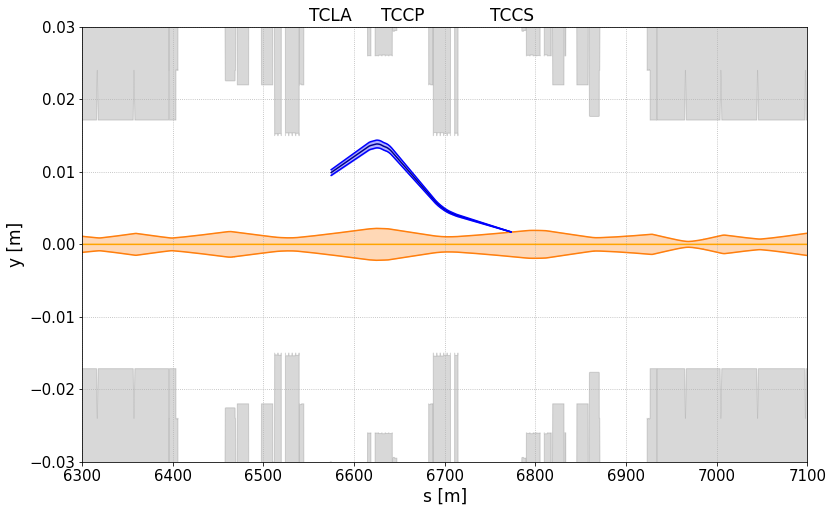

In [39]:
run_cry_tracking(line_name = line_name_RUN3, normalized_emittance = normalized_emittance_RUN3, ax_plot = True, coll_name = coll_name_RUN3,  n_sigma = 5)

In [15]:
line_name_HL_phase_rematched= './input_files/HL_rematched_phase_avdance.json'
normalized_emittance_HL = 2.5e-6
coll_name_HL = './input_files/CollDB_HL_tight_b4.data'

In [16]:
run_cry_tracking(line_name = line_name_HL_phase_rematched, normalized_emittance = normalized_emittance_HL, ax_plot = False, coll_name = coll_name_HL, n_sigma = 7.2)

Loading line from dict:   0%|          | 0/61374 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.2

Upper: 38.31 sigma, 11.77 mm
Central: 36.97 sigma, 11.36 mm
Lower: 35.63 sigma, 10.94 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.36,12.36] mm
Jaw sigma in order to center: 33.7


In [123]:
line_name_HL_tune= './input_files/HL_IR7_tune_changed/b4_sequence_patched_tune.json'
normalized_emittance_HL = 2.5e-6
coll_name_HL = './input_files/colldbs/HL_tight_twocryst.yaml'

Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Energy: 7000.00 GeV 	 TCCS sigma setting: 7.2

Upper: 38.21 sigma, 11.74 mm
Central: 36.87 sigma, 11.33 mm
Lower: 35.53 sigma, 10.92 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.82 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.33,12.33] mm
Jaw sigma in order to center: 33.6


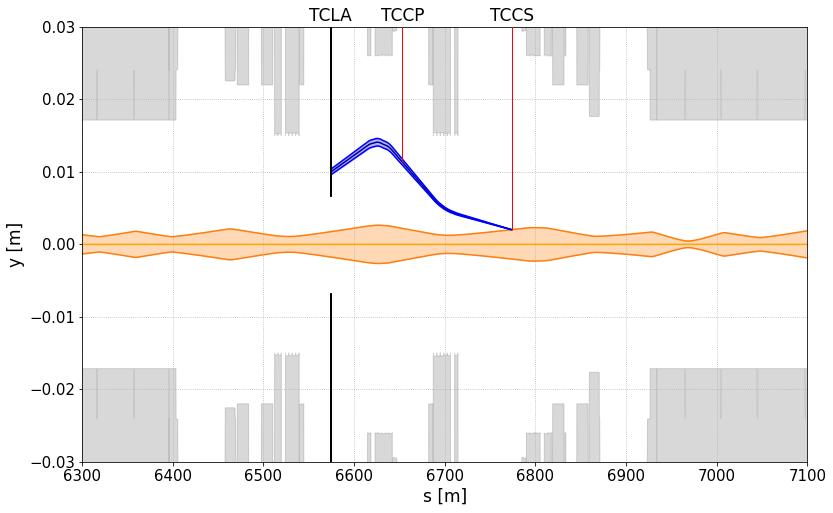

In [130]:
fig, ax = run_cry_tracking(line_name = line_name_HL_tune, normalized_emittance = normalized_emittance_HL, ax_plot = True, coll_name = coll_name_HL, n_sigma = 7.2, return_plot = True)

In [131]:
fig.savefig('./Plots/HL_one_part.png')

# Twocryst

In [17]:
#line_name_Run3_inj= './input_files/2024_Run3/injection_b2.json'
#normalized_emittance_Run3 = 3.5e-6
#coll_name_Run3_inj = './input_files/colldbs/injection.yaml' # with TCLA closed!!!

In [ ]:
TWOCRYST_line= './MadX/2025/injection/track_injection_b2.json'
normalized_emittance_Run3 = 3.5e-6
TWOCRYST_colls = './input_files/colldbs/TWOCRYST_colldb_450GeV.yaml' # with TCLA closed!!!

### Injection

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 450.0 GeV



Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker

Energy: 450.00 GeV 	 TCCS sigma setting: 5.0

Upper: 11.38 sigma, 16.38 mm
Central: 10.12 sigma, 14.57 mm
Lower: 8.86 sigma, 12.75 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 3.63 mm   	Crystal height: 2 mm
Center the spot in the crystal: [13.57,15.57] mm
Jaw sigma in order to center: 9.4

Pixel lower bound (+1.5mm margin): 4.88 sigma, 7.07 mm
Alfa lower bound (+1.5mm margin): 6.37 sigma, 9.28 mm


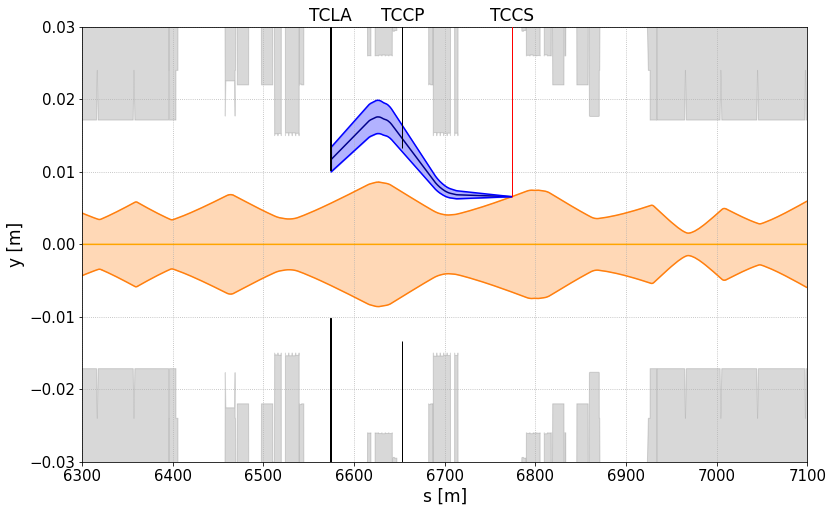

In [15]:
run_cry_tracking(n_sigma = 5.0, part_energy = 450e9, line_name = TWOCRYST_line, normalized_emittance = normalized_emittance_Run3, ax_plot = True, coll_name = TWOCRYST_colls, TCLA_gap = 9.0)

### 1 TeV

In [ ]:
TWOCRYST_line= './MadX/2025/injection/track_injection_b2.json'
normalized_emittance_Run3 = 3.5e-6
TWOCRYST_colls = './input_files/colldbs/TWOCRYST_colldb_1-3TeV.yaml'

"line_name_Run3_1TeV= './input_files/2024_Run3/ramp.9_b2.json'\nnormalized_emittance_Run3 = 3.5e-6\ncoll_name_Run3_1TeV = './input_files/colldbs/ramp.9.yaml'"

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 1000.0 GeV



Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker

Energy: 1000.00 GeV 	 TCCS sigma setting: 5.0

Upper: 14.75 sigma, 14.24 mm
Central: 13.51 sigma, 13.05 mm
Lower: 12.27 sigma, 11.85 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 2.39 mm   	Crystal height: 2 mm
Center the spot in the crystal: [12.05,14.05] mm
Jaw sigma in order to center: 12.5

Pixel lower bound (+1.5mm margin): 6.35 sigma, 6.17 mm
Alfa lower bound (+1.5mm margin): 8.56 sigma, 8.37 mm


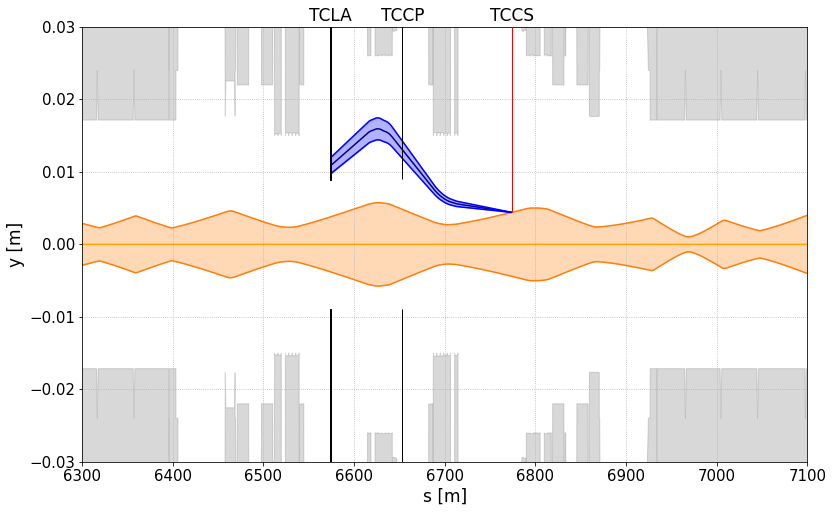

In [58]:
run_cry_tracking(n_sigma = 5.0, line_name = TWOCRYST_line, part_energy = 1000e9,  normalized_emittance = normalized_emittance_Run3, ax_plot = True, coll_name = TWOCRYST_colls)

### 3 TeV

In [ ]:
TWOCRYST_line= './MadX/2025/injection/track_injection_b2.json'
normalized_emittance_Run3 = 3.5e-6
TWOCRYST_colls = './input_files/colldbs/TWOCRYST_colldb_1-3TeV.yaml'

"line_name_Run3_3TeV= './input_files/2024_Run3/ramp.17_b2.json'\nnormalized_emittance_Run3 = 3.5e-6\ncoll_name_Run3_3TeV = './input_files/colldbs/ramp.17.yaml'"

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 3000.0 GeV



Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker

Energy: 3000.00 GeV 	 TCCS sigma setting: 5.0

Upper: 22.22 sigma, 12.39 mm
Central: 21.05 sigma, 11.74 mm
Lower: 19.89 sigma, 11.09 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 1.30 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.74,12.74] mm
Jaw sigma in order to center: 19.3

Pixel lower bound (+1.5mm margin): 9.64 sigma, 5.41 mm
Alfa lower bound (+1.5mm margin): 13.48 sigma, 7.61 mm


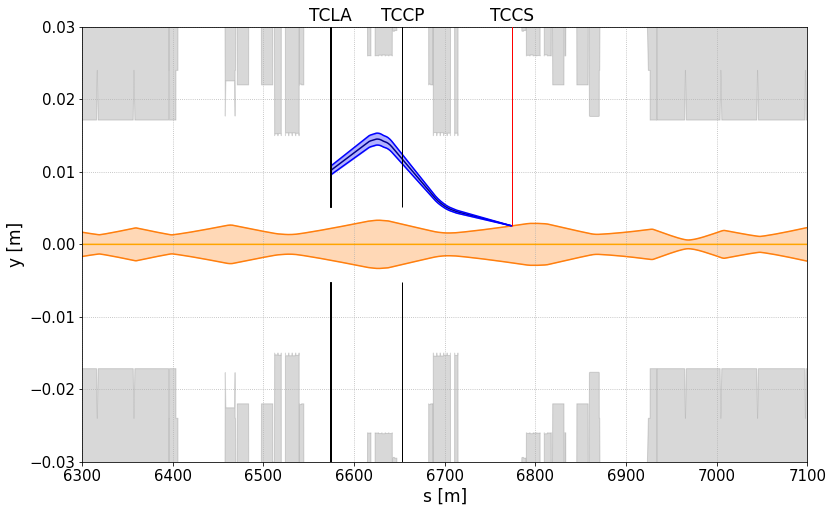

In [16]:
run_cry_tracking(n_sigma = 5.0, part_energy=3000e9, line_name = TWOCRYST_line, normalized_emittance = normalized_emittance_Run3, ax_plot = True, coll_name = TWOCRYST_colls)

### 5 TeV

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 5000.0 GeV



Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker

Energy: 5000.00 GeV 	 TCCS sigma setting: 5.0

Upper: 27.34 sigma, 11.80 mm
Central: 26.25 sigma, 11.33 mm
Lower: 25.16 sigma, 10.86 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.94 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.33,12.33] mm
Jaw sigma in order to center: 23.9

Pixel lower bound (+1.5mm margin): 11.93 sigma, 5.18 mm
Alfa lower bound (+1.5mm margin): 16.89 sigma, 7.38 mm


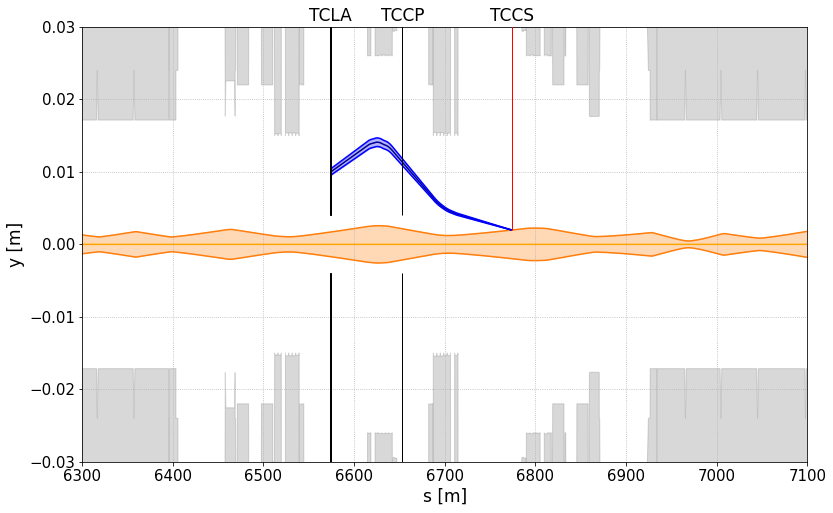

In [17]:
run_cry_tracking(n_sigma = 5.0, part_energy=5000e9, line_name = TWOCRYST_line, normalized_emittance = normalized_emittance_Run3, ax_plot = True, coll_name = TWOCRYST_colls)

### Flat top

In [16]:
TWOCRYST_ft= './MadX/2025/flat_top/track_flat_top_b2.json'
normalized_emittance_Run3 = 3.5e-6
TWOCRYST_ft_colls = './input_files/colldbs/TWOCRYST_colldb_6.8TeV.yaml'

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 6800.0 GeV



Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker

Energy: 6800.00 GeV 	 TCCS sigma setting: 5.5

Upper: 31.46 sigma, 11.63 mm
Central: 30.44 sigma, 11.25 mm
Lower: 29.41 sigma, 10.88 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 0.76 mm   	Crystal height: 2 mm
Center the spot in the crystal: [10.25,12.25] mm
Jaw sigma in order to center: 27.7

Pixel lower bound (+1.5mm margin): 13.96 sigma, 5.19 mm
Alfa lower bound (+1.5mm margin): 19.76 sigma, 7.40 mm


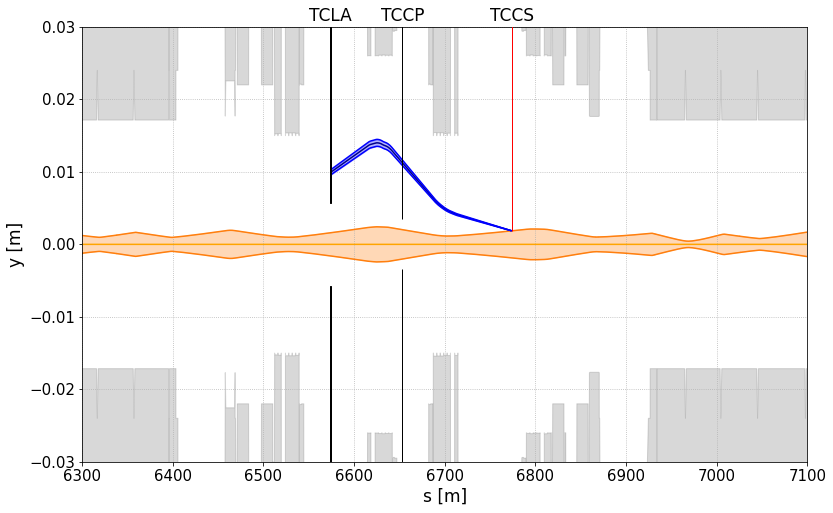

In [17]:
run_cry_tracking(n_sigma = 5.5, part_energy=6800e9, line_name = TWOCRYST_ft, normalized_emittance = normalized_emittance_Run3, ax_plot = True, coll_name = TWOCRYST_ft_colls)